In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#basics
import sys,os

#utils
import paths

#main libraries
import pandas as pd

#model Libraries
from sklearn import utils
from sklearn import preprocessing

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

In [3]:
#private modules 
#data
from src.data import make_dataset

#utils
from src.utils import memory_usage

#model
from src.models import train_model
from src.models import evaluation

In [35]:
%%time
df_training,features,target = make_dataset.get_data(nrows=5000, low_memory=False, dataset="training")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 314 entries, id to target_kazutsugi
dtypes: float64(311), int32(1), object(2)
memory usage: 12.0+ MB
None
CPU times: user 888 ms, sys: 631 ms, total: 1.52 s
Wall time: 24.1 s


In [ ]:
%%time
#df_tournament,features,target = make_dataset.get_data(nrows=5000, low_memory=False, dataset="tournament")

In [36]:
#encoding target to multiclass
lab_enc = preprocessing.LabelEncoder()
encoded_target_train = lab_enc.fit_transform(df_training[target])
#encoded_target_tournament = lab_enc.fit_transform(df_tournament[target])

In [37]:
memory_usage.memory()

Available memory (%): 21.953296661376953


In [38]:
results, res_cv = list(), dict()

In [39]:
rf_param_grid =  {
    'rf__n_estimators' : [10],
}


#encoding target to multiclass
lab_enc = preprocessing.LabelEncoder()
encoded_target_train = lab_enc.fit_transform(df_training[target])


#Group K-fold
CV = GroupKFold(n_splits = 3)
grp = list(CV.split(X = df_training[features], y = df_training[target],  groups = df_training.era.values))


#scorer function
scorer = make_scorer(roc_auc_score, multi_class='ovr', needs_proba=True)

result = evaluation.evaluate_model(df_training[features], encoded_target_train,
                                   RandomForestClassifier(), 'rf',
                                   rf_param_grid, 
                                   scorer, 
                                   n_iter=1, 
                                   cv_folds=grp,
                                   pipeline=None)

results.append(result)
res_cv[result[1]] = evaluation.get_cv_scores(result[0])

==> Starting [(array([2408, 2409, 2410, ..., 4997, 4998, 4999]), array([   0,    1,    2, ..., 2405, 2406, 2407])), (array([   0,    1,    2, ..., 4997, 4998, 4999]), array([2408, 2409, 2410, ..., 4776, 4777, 4778])), (array([   0,    1,    2, ..., 4776, 4777, 4778]), array([4779, 4780, 4781, 4782, 4783, 4784, 4785, 4786, 4787, 4788, 4789,
       4790, 4791, 4792, 4793, 4794, 4795, 4796, 4797, 4798, 4799, 4800,
       4801, 4802, 4803, 4804, 4805, 4806, 4807, 4808, 4809, 4810, 4811,
       4812, 4813, 4814, 4815, 4816, 4817, 4818, 4819, 4820, 4821, 4822,
       4823, 4824, 4825, 4826, 4827, 4828, 4829, 4830, 4831, 4832, 4833,
       4834, 4835, 4836, 4837, 4838, 4839, 4840, 4841, 4842, 4843, 4844,
       4845, 4846, 4847, 4848, 4849, 4850, 4851, 4852, 4853, 4854, 4855,
       4856, 4857, 4858, 4859, 4860, 4861, 4862, 4863, 4864, 4865, 4866,
       4867, 4868, 4869, 4870, 4871, 4872, 4873, 4874, 4875, 4876, 4877,
       4878, 4879, 4880, 4881, 4882, 4883, 4884, 4885, 4886, 4887, 4888,
 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished


==> Elapsed seconds: 4.377
Best rf model: RandomForestClassifier(n_estimators=10)
Best rf score (val): 0.536


In [45]:
rf_param_grid =  {
    #'rf__bootstrap' : [True, False],
    #'rf__ccp_alpha' : 0.0, 
    #'rf__class_weight': [None, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}, 'balanced'],
    #'rf__criterion' : 'gini', 
    #'rf__max_depth' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 
    #'rf__max_features' : ['auto', 'sqrt'],
    #'rf__max_leaf_nodes' : None,
    #'rf__max_samples' : None,
    #'rf__min_impurity_decrease' : 0.0, 
    #'rf__min_impurity_split' : None,
    #'rf__min_samples_leaf' : [1, 2, 4],
    #'rf__min_samples_split' : [2, 5, 10],
    #'rf__min_weight_fraction_leaf' : 0.0, 
    'rrf__n_estimators' : [10, 20],#, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    #'rf__oob_score' : False, 
    #'rf__random_state' : None,
    #'rf__verbose' : 0, 
    #'rf__warm_start' : False
}


scorer = make_scorer(mean_squared_error)

result = evaluation.evaluate_model(df_training[features], encoded_target_train,
                                   RandomForestRegressor(), 'rrf',
                                   rf_param_grid, 
                                   scorer, n_iter=2, 
                                   cv_folds=grp, pipeline=None)

results.append(result)
res_cv[result[1]] = evaluation.get_cv_scores(result[0])

==> Starting K-fold cross validation for rrf model, 5000 examples
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    6.3s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   12.0s finished


==> Elapsed seconds: 15.729
Best rrf model: RandomForestRegressor(n_estimators=10)
Best rrf score (val): 2.261


In [40]:
file_path = '../../models/rf-baseline.pkl'

model = list(filter(lambda x: x[1] == 'rf', results))[0][0]
model.save(file_path)

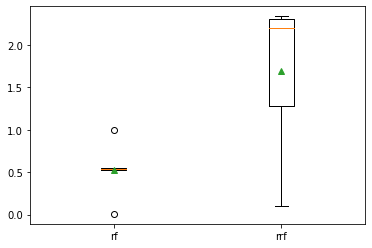

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.boxplot(res_cv.values(), labels=res_cv.keys(), showmeans=True)

In [ ]:
#rascunho
from joblib import dump, load
dump(model.model, file_path)
model23 = load(file_path)

### 2a parte h20

In [ ]:
#### ALL ABOUT eras Validacao, cv_results(boxplot) e metricas e h20

In [4]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [5]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_231"; Java(TM) SE Runtime Environment (build 1.8.0_231-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.231-b11, mixed mode)
  Starting server from /Users/nicholasrichers/Documents/virtualenvs/numerai_env/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/h3/qyfbykxs3jxflfr3kk8hdjcr0000gn/T/tmp9ufydwhi
  JVM stdout: /var/folders/h3/qyfbykxs3jxflfr3kk8hdjcr0000gn/T/tmp9ufydwhi/h2o_nicholasrichers_started_from_python.out
  JVM stderr: /var/folders/h3/qyfbykxs3jxflfr3kk8hdjcr0000gn/T/tmp9ufydwhi/h2o_nicholasrichers_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_nicholasrichers_g6cq06
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,902 Mb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [9]:
train_path = "https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz"
tournament_path = "https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz"

response = "target_kazutsugi"
file_path = '../../data/raw/numerai_training_data.csv'
tournament_path = '../../data/raw/numerai_tournament_data.csv'

In [14]:
df = h2o.import_file(path = file_path, sep=',', header=1)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [23]:
df.describe()

Rows:501808
Cols:314




,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,feature_charisma26,feature_charisma27,feature_charisma28,feature_charisma29,feature_charisma30,feature_charisma31,feature_charisma32,feature_charisma33,feature_charisma34,feature_charisma35,feature_charisma36,feature_charisma37,feature_charisma38,feature_charisma39,feature_charisma40,feature_charisma41,feature_charisma42,feature_charisma43,feature_charisma44,feature_charisma45,feature_charisma46,feature_charisma47,feature_charisma48,feature_charisma49,feature_charisma50,feature_charisma51,feature_charisma52,feature_charisma53,feature_charisma54,feature_charisma55,feature_charisma56,feature_charisma57,feature_charisma58,feature_charisma59,feature_charisma60,feature_charisma61,feature_charisma62,feature_charisma63,feature_charisma64,feature_charisma65,feature_charisma66,feature_charisma67,feature_charisma68,feature_charisma69,feature_charisma70,feature_charisma71,feature_charisma72,feature_charisma73,feature_charisma74,feature_charisma75,feature_charisma76,feature_charisma77,feature_charisma78,feature_charisma79,feature_charisma80,feature_charisma81,feature_charisma82,feature_charisma83,feature_charisma84,feature_charisma85,feature_charisma86,feature_strength1,feature_strength2,feature_strength3,feature_strength4,feature_strength5,feature_strength6,feature_strength7,feature_strength8,feature_strength9,feature_strength10,feature_strength11,feature_strength12,feature_strength13,feature_strength14,feature_strength15,feature_strength16,feature_strength17,feature_strength18,feature_strength19,feature_strength20,feature_strength21,feature_strength22,feature_strength23,feature_strength24,feature_strength25,feature_strength26,feature_strength27,feature_strength28,feature_strength29,feature_strength30,feature_strength31,feature_strength32,feature_strength33,feature_strength34,feature_strength35,feature_strength36,feature_strength37,feature_strength38,feature_dexterity1,feature_dexterity2,feature_dexterity3,feature_dexterity4,feature_dexterity5,feature_dexterity6,feature_dexterity7,feature_dexterity8,feature_dexterity9,feature_dexterity10,feature_dexterity11,feature_dexterity12,feature_dexterity13,feature_dexterity14,feature_constitution1,feature_constitution2,feature_constitution3,feature_constitution4,feature_constitution5,feature_constitution6,feature_constitution7,feature_constitution8,feature_constitution9,feature_constitution10,feature_constitution11,feature_constitution12,feature_constitution13,feature_constitution14,feature_constitution15,feature_constitution16,feature_constitution17,feature_constitution18,feature_constitution19,feature_constitution20,feature_constitution21,feature_constitution22,feature_constitution23,feature_constitution24,feature_constitution25,feature_constitution26,feature_constitution27,feature_constitution28,feature_constitution29,feature_constitution30,feature_constitution31,feature_constitution32,feature_constitution33,feature_constitution34,feature_constitution35,feature_constitution36,feature_constitution37,feature_constitution38,feature_constitution39,feature_constitution40,feature_constitution41,feature_constitution42,feature_constitution43,feature_constitution44,feature_constitution45,feature_constitution46,feature_constitution47,feature_constitution48,feature_con

In [21]:
df[response] = df[response].ascharacter().asfactor()

In [31]:
predictors = df.columns[3:-1]
gbm = H2OGradientBoostingEstimator()
gbm.train(x=predictors, y=response, training_frame=df)

/Users/nicholasrichers/Documents/virtualenvs/numerai_env/lib/python3.8/site-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Dropping bad and constant columns: [data_type, id]
  warnings.warn(mesg["message"], RuntimeWarning)


gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [47]:
print(gbm)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1597566247245_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,250.0,171204.0,5.0,5.0,5.0,32.0,32.0,32.0




ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.6111345224704894
RMSE: 0.781750933782934
LogLoss: 1.545020114014453
Mean Per-Class Error: 0.6834223883661046

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,0.25,0.5,0.75,1,Error,Rate
0,36906.0,10655.0,17367.0,10294.0,24820.0,0.631095,"63,136 / 100,042"
1,19208.0,19478.0,29516.0,12081.0,19763.0,0.805310,"80,568 / 100,046"
2,17169.0,11308.0,42771.0,11978.0,18406.0,0.579158,"58,861 / 101,632"
3,17782.0,11590.0,29509.0,19953.0,21207.0,0.800552,"80,088 / 100,041"
4,22420.0,9278.0,17205.0,11225.0,39919.0,0.600998,"60,128 / 100,047"
5,113485.0,62309.0,136368.0,65531.0,124115.0,0.683092,"342,781 / 501,808"



Top-5 Hit Ratios: 


,k,hit_ratio
0,1,0.316908
1,2,0.547847
2,3,0.734273
3,4,0.888332
4,5,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error
0,,2020-08-16 05:40:23,0.131 sec,0.0,0.800000,1.609438,0.800306
1,,2020-08-16 05:41:23,1 min 0.092 sec,1.0,0.798649,1.602950,0.739857
2,,2020-08-16 05:42:06,1 min 42.908 sec,2.0,0.797447,1.597571,0.736598
3,,2020-08-16 05:42:46,2 min 23.102 sec,3.0,0.796367,1.593051,0.734446
4,,2020-08-16 05:43:27,3 min 4.005 sec,4.0,0.795397,1.589224,0.732268
5,,2020-08-16 05:44:08,3 min 44.383 sec,5.0,0.794510,1.585898,0.730170
6,,2020-08-16 05:44:45,4 min 22.227 sec,6.0,0.793707,1.583035,0.729492
7,,2020-08-16 05:45:23,4 min 59.488 sec,7.0,0.792975,1.580540,0.728518
8,,2020-08-16 05:46:08,5 min 45.176 sec,8.0,0.792311,1.578389,0.727685
9,,2020-08-16 05:46:49,6 min 26.233 sec,9.0,0.791697,1.576428,0.725784



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,era,20176.812500,1.000000,0.300251
1,feature_intelligence8,18633.714844,0.923521,0.277288
2,feature_intelligence4,6727.462891,0.333425,0.100111
3,feature_intelligence1,4635.756836,0.229757,0.068985
4,feature_dexterity11,1430.527588,0.070900,0.021288
5,feature_wisdom14,875.229980,0.043378,0.013024
6,feature_constitution2,497.764832,0.024670,0.007407
7,feature_strength19,476.524139,0.023617,0.007091
8,feature_wisdom35,378.717651,0.018770,0.005636
9,feature_constitution54,378.375275,0.018753,0.005631



See the whole table with table.as_data_frame()



In [54]:
gbm._model_json['output']['variable_importances'].as_data_frame()

,variable,relative_importance,scaled_importance,percentage
0,era,20176.812500,1.000000,0.300251
1,feature_intelligence8,18633.714844,0.923521,0.277288
2,feature_intelligence4,6727.462891,0.333425,0.100111
3,feature_intelligence1,4635.756836,0.229757,0.068985
4,feature_dexterity11,1430.527588,0.070900,0.021288
...,...,...,...,...
306,feature_charisma22,2.660679,0.000132,0.000040
307,feature_strength30,1.781751,0.000088,0.000027
308,feature_wisdom45,1.602460,0.000079,0.000024
309,feature_charisma30,0.000000,0.000000,0.000000


In [6]:
model_path = '/Users/nicholasrichers/Documents/GitHub/dissertacao/notebooks/Baseline/GBM_model_python_1597566247245_1'

In [55]:
# save the model
#model_path = h2o.save_model(model=gbm, path="", force=True)
print(model_path)

/Users/nicholasrichers/Documents/GitHub/dissertacao/notebooks/Baseline/GBM_model_python_1597566247245_1


In [7]:
# load the model
saved_model = h2o.load_model(model_path)

In [10]:
df_tournament = h2o.import_file(path = tournament_path, sep=',', header=1)
df_tournament[response] = df_tournament[response].ascharacter().asfactor()

Parse progress: |████████████████████████████████████████████████████████ (failed)  99%


OSError: Job with key $03017f00000132d4ffffffff$_8988155d7c40fd0c421b413e59fd495d failed with an exception: DistributedException from /127.0.0.1:54321: 'Java heap space', caused by java.lang.OutOfMemoryError: Java heap space
stacktrace: 
DistributedException from /127.0.0.1:54321: 'Java heap space', caused by java.lang.OutOfMemoryError: Java heap space
	at water.MRTask.getResult(MRTask.java:494)
	at water.MRTask.getResult(MRTask.java:502)
	at water.MRTask.doAll(MRTask.java:409)
	at water.parser.ParseDataset.parseAllKeys(ParseDataset.java:254)
	at water.parser.ParseDataset.access$000(ParseDataset.java:26)
	at water.parser.ParseDataset$ParserFJTask.compute2(ParseDataset.java:203)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1563)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:974)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1477)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)
Caused by: java.lang.OutOfMemoryError: Java heap space


In [9]:
df_tournament.summary()

'../../data/raw/numerai_tournament_data.csv'

In [ ]:
%%time
predictors = df.columns[:-1]

saved_model.predict(x=predictors, y=response, training_frame=df_tournament)

### 3a parte h20

In [ ]:
#### ALL ABOUT eras Validacao e metricas

Rascunho

In [ ]:
%%time
#from joblib import parallel_backend

#with parallel_backend('threading', n_jobs=-1):
    # Train the model
    #model = RandomForestClassifier(n_estimators=10, n_jobs=-1)
    #model.fit(df_training[features], encoded_target_train)
    # Test the model
    #y_pred = clf.predict(X_test)
